In [5]:
from pathlib import Path
import numpy as np
from scipy.fft import rfft, rfftfreq
from matplotlib import pyplot as plt
import os

In [6]:
%matplotlib inline

## Load signals

In [7]:
# base = Path('data/vibrations/')

# experiments = {}
# for f in os.listdir(base):
#     if os.path.isdir(os.path.join(base, f)):
#         experiments[f] = {'all_shifts': np.load(base / f / 'RECOVERY.npz', allow_pickle=True)['all_shifts'],
#                    'run_opt': np.load(base / f / 'metadata.npz', allow_pickle=True)['run_opt'].item()}
# experiments.keys()

In [8]:
# data = experiments['cube_pos2_29_12_Time_19_13_50']
# data['all_shifts'].shape

In [9]:
# data['run_opt']

In [22]:
base = Path('data/vibrations/')

experiments_list = sorted([f for f in os.listdir(base) if os.path.isdir(os.path.join(base, f))])
print(experiments_list)

all_shifts_list = []
run_opt_list    = []

for experiment in experiments_list:
    all_shifts_list.append( np.load(base / experiment / 'RECOVERY.npz', allow_pickle=True)['all_shifts'] )
    run_opt_list.append( np.load(base / experiment / 'metadata.npz', allow_pickle=True)['run_opt'].item())

['cube_pos1_29_12_Time_19_16_40', 'cube_pos2_29_12_Time_19_03_39', 'cube_pos2_29_12_Time_19_13_50', 'cube_pos3_29_12_Time_19_27_21', 'cube_pos3_29_12_Time_19_29_43', 'cube_pos4_29_12_Time_19_24_21', 'cube_pos5_29_12_Time_19_22_12', 'cube_pos6_29_12_Time_19_20_07']


In [23]:
all_shifts_list[0].shape

(100, 30000, 2)

* 100 because we have a 10x10 grid of laser points
* 30,000 because we have 6 seconds of data with 5_000 frames per second
* 2 for ?

In [24]:
run_opt_list[0]

{'cam_params': {'camera_FPS': 5000,
  'exposure': 150,
  'gain': 1,
  'get_global_roi': (368, 0, 944, 300),
  'get_frame_rate': 5000,
  'get_max_frame_rate': 7970,
  'get_exposure': 150},
 'run_opt_multiROIs': {'N_ROIs': 10,
  'ROI_height': 30,
  'ROIs': [(17, 0, 70, 30),
   (113, 0, 70, 30),
   (207, 0, 70, 30),
   (295, 0, 70, 30),
   (386, 0, 70, 30),
   (480, 0, 70, 30),
   (577, 0, 70, 30),
   (671, 0, 70, 30),
   (766, 0, 70, 30),
   (862, 0, 70, 30),
   (17, 30, 70, 30),
   (113, 30, 70, 30),
   (207, 30, 70, 30),
   (295, 30, 70, 30),
   (386, 30, 70, 30),
   (480, 30, 70, 30),
   (577, 30, 70, 30),
   (671, 30, 70, 30),
   (766, 30, 70, 30),
   (862, 30, 70, 30),
   (17, 60, 70, 30),
   (113, 60, 70, 30),
   (207, 60, 70, 30),
   (295, 60, 70, 30),
   (386, 60, 70, 30),
   (480, 60, 70, 30),
   (577, 60, 70, 30),
   (671, 60, 70, 30),
   (766, 60, 70, 30),
   (862, 60, 70, 30),
   (17, 90, 70, 30),
   (113, 90, 70, 30),
   (207, 90, 70, 30),
   (295, 90, 70, 30),
   (386, 90, 

In [ ]:
def all_shifts_to_freqs(all_shifts, laser_idx, run_opt):
    data = all_shifts[laser_idx, :, 0]
    fps = run_opt['cam_params']['get_frame_rate']
    n = len(data)

    # 2. Compute FFT and the corresponding frequencies in Hz
    # Subtracting the mean is still good practice to reduce leakage
    yf = rfft(data - np.mean(data))
    xf = rfftfreq(n, d=1/fps)
    return xf, yf

In [26]:
def experiment_to_name(experiment):
    return f'Cube Pos {experiment.lstrip("cube_pos")[0]}'

In [77]:
def plot(laser_idx, min_freq=50, max_freq=2_000, window_size=1):

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_title(f"Laser {laser_idx} Frequency Spectrum ({min_freq}Hz to {max_freq}Hz)")

    for i in range(len(experiments_list)):
        all_shifts = all_shifts_list[i]
        run_opt = run_opt_list[i]
        experiment = experiments_list[i]

        xf, yf = all_shifts_to_freqs(all_shifts, laser_idx, run_opt)

        # 3. Create a mask for your desired range (50Hz - 2000Hz)
        mask = (xf >= min_freq) & (xf <= max_freq)

        # Apply sliding window (moving average) smoothing
        yf_masked = np.abs(yf[mask])
        kernel = np.ones(window_size) / window_size
        yf_smoothed = np.convolve(yf_masked, kernel, mode='same')

        # 4. Plot
        ax.plot(xf[mask], yf_smoothed, label=experiment_to_name(experiment), linewidth=1)

        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Magnitude")
        ax.grid(True)
        plt.legend()
    return fig

In [78]:
%matplotlib inline

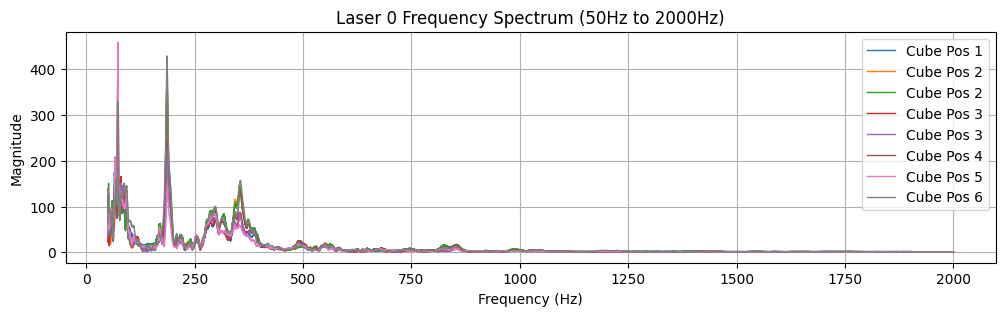

In [79]:
fig = plot(0, window_size=5)
plt.show()

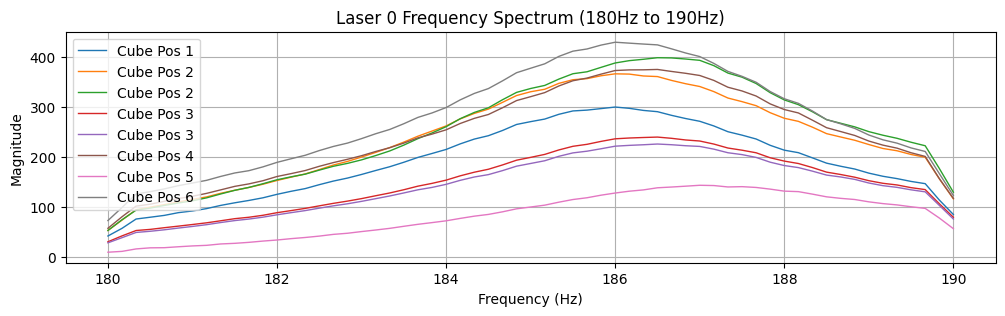

In [80]:
fig = plot(0, min_freq=180, max_freq=190, window_size=5)
plt.show()

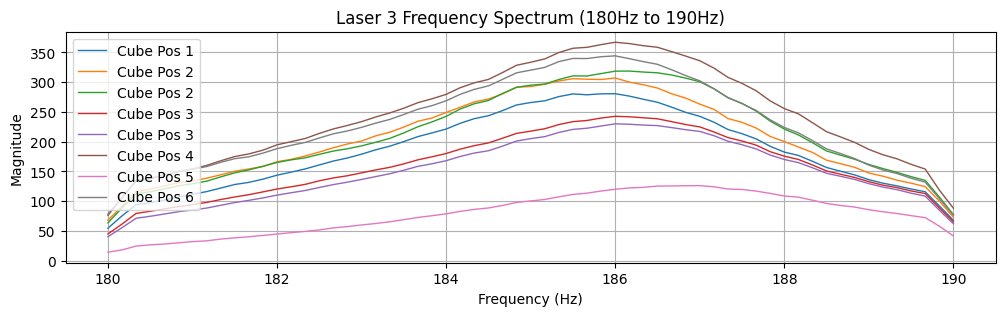

In [83]:
fig = plot(3, min_freq=180, max_freq=190, window_size=5)
plt.show()

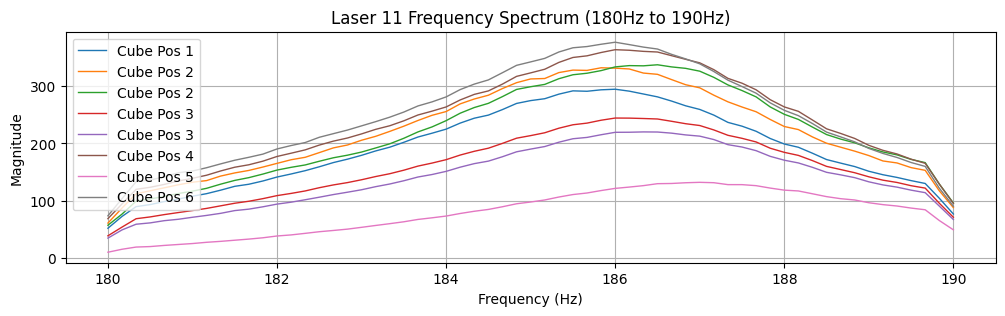

In [85]:
fig = plot(11, min_freq=180, max_freq=190, window_size=5)
plt.show()

In [91]:
def plot_averaged(laser_idxs, min_freq=50, max_freq=2_000, window_size=1):
    """
    Plot frequency spectrum averaged over all laser_idxs for each experiment.
    Shows mean with standard deviation as shaded region.
    """
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_title(f"Frequency Spectrum Averaged Over {len(laser_idxs)} Lasers ({min_freq}Hz to {max_freq}Hz)")

    for i in range(len(experiments_list)):
        all_shifts = all_shifts_list[i]
        run_opt = run_opt_list[i]
        experiment = experiments_list[i]

        # Collect spectra for all laser indices
        spectra = []
        for laser_idx in laser_idxs:
            xf, yf = all_shifts_to_freqs(all_shifts, laser_idx, run_opt)

            # Create a mask for desired frequency range
            mask = (xf >= min_freq) & (xf <= max_freq)

            # Apply sliding window (moving average) smoothing
            yf_masked = np.abs(yf[mask])
            kernel = np.ones(window_size) / window_size
            yf_smoothed = np.convolve(yf_masked, kernel, mode='same')

            spectra.append(yf_smoothed)

        # Convert to array and compute mean/std across laser indices
        spectra = np.array(spectra)
        mean_spectrum = np.mean(spectra, axis=0)
        std_spectrum = np.std(spectra, axis=0)

        # Get x-axis values (same for all laser indices)
        xf_masked = xf[mask]

        # Plot mean with std as shaded region
        label = experiment_to_name(experiment)
        line, = ax.plot(xf_masked, mean_spectrum, label=label, linewidth=1)
        ax.plot(xf_masked, mean_spectrum - std_spectrum, linestyle='--', alpha=0.5, color=line.get_color(), linewidth=0.5)
        ax.plot(xf_masked, mean_spectrum + std_spectrum, linestyle='--', alpha=0.5, color=line.get_color(), linewidth=0.5)

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")
    ax.grid(True)
    ax.legend()

    return fig

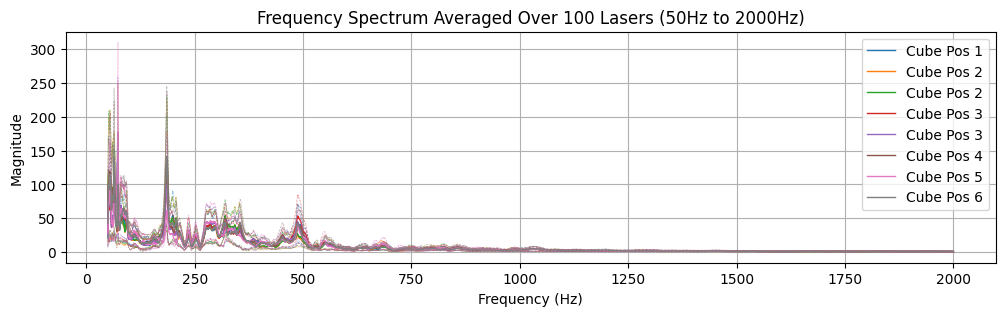

In [94]:
fig = plot_averaged(np.arange(all_shifts_list[0].shape[0]), window_size=5)
plt.show()

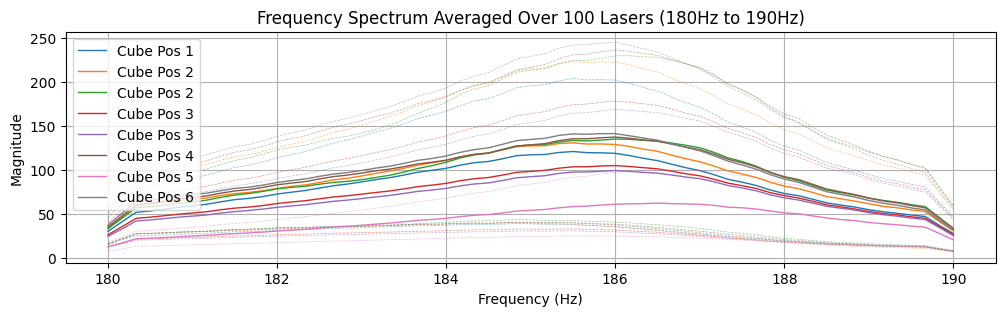

In [93]:
fig = plot_averaged(np.arange(all_shifts_list[0].shape[0]), window_size=5, min_freq=180, max_freq=190)
plt.show()